In [53]:
import pandas as pd


df = pd.read_csv("european_capitals_history_full2.csv")
df['time'] = pd.to_datetime(df['time'])

print(" Informacje o datasetcie:")
print(df.info())


print(" Liczba braków w każdej kolumnie:")
print(df.isnull().sum())


missing_by_city = df.groupby('city').apply(lambda x: x.isnull().sum())

print("Liczba braków w każdej kolumnie, podzielona na miasta:")
print(missing_by_city)

 Informacje o datasetcie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76432 entries, 0 to 76431
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    76432 non-null  datetime64[ns]
 1   temp    76432 non-null  float64       
 2   tmin    76431 non-null  float64       
 3   tmax    76432 non-null  float64       
 4   prcp    64623 non-null  float64       
 5   wspd    75290 non-null  float64       
 6   pres    75294 non-null  float64       
 7   city    76432 non-null  object        
 8   lat     76432 non-null  float64       
 9   lon     76432 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 5.8+ MB
None
 Liczba braków w każdej kolumnie:
time        0
temp        0
tmin        1
tmax        0
prcp    11809
wspd     1142
pres     1138
city        0
lat         0
lon         0
dtype: int64
Liczba braków w każdej kolumnie, podzielona na miasta:
            time  t

C:\Users\gduls\AppData\Local\Temp\ipykernel_11372\2202830016.py:15: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [54]:
for city in df['city'].unique():
    city_df = df[df['city'] == city].set_index('time').sort_index()
    full_range = pd.date_range(start=city_df.index.min(), end=city_df.index.max(), freq='D')
    missing_dates = full_range.difference(city_df.index)
    
    if len(missing_dates) > 0:
        print(f"{city}: brakujące daty ({len(missing_dates)} dni)")
        print(missing_dates)


Berlin: brakujące daty (12 dni)
DatetimeIndex(['2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13'],
              dtype='datetime64[ns]', freq='D')
Paryż: brakujące daty (16 dni)
DatetimeIndex(['2020-01-13', '2020-03-13', '2020-03-14', '2020-08-25',
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2025-03-14', '2025-03-15', '2025-03-16', '2025-03-17',
               '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21'],
              dtype='datetime64[ns]', freq=None)
Londyn: brakujące daty (12 dni)
DatetimeIndex(['2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13'],
              dtype='datetime64[ns]', freq='D')
Wiedeń: brakujące daty (11 dni)
DatetimeIndex([

In [55]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values(['city', 'time'])

cols_to_fill = ['tmin', 'prcp', 'wspd', 'pres']

# Interpolacja czasowa per miasto
def interpolate_city(group):
    # Ustawiamy czas jako indeks
    group = group.set_index('time')
    # Interpolacja tylko na brakach
    group[cols_to_fill] = group[cols_to_fill].interpolate(method='time')
    # Przywracamy indeks 'time' jako kolumnę
    return group.reset_index()

df = df.groupby('city', group_keys=False).apply(interpolate_city)
print(df[cols_to_fill].isnull().sum())

tmin        1
prcp    11809
wspd     1142
pres     1138
dtype: int64


C:\Users\gduls\AppData\Local\Temp\ipykernel_11372\3587784633.py:15: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [56]:

#  Sprawdzenie braków po czyszczeniu
print(" Braki danych po wypełnieniu:")
print(df.isnull().sum())

df['temp_rolling3'] = df.groupby('city')['temp'].transform(lambda x: x.rolling(3).mean())
df['temp_diff1'] = df.groupby('city')['temp'].diff()

df_final = df.dropna(subset=['temp_rolling3', 'temp_diff1']).reset_index(drop=True)


#  Zapis do nowego CSV
df_final.to_csv("european_capitals_history_clean2.csv", index=False)
print(" Czysty dataset zapisany: european_capitals_history_clean2.csv")

 Braki danych po wypełnieniu:
time        0
temp        0
tmin        1
tmax        0
prcp    11809
wspd     1142
pres     1138
city        0
lat         0
lon         0
dtype: int64
 Czysty dataset zapisany: european_capitals_history_clean2.csv


In [57]:
cols = ['temp','tmin','tmax','prcp','wspd','pres']
for col in cols:
    q1 = df_final[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df_final[col] = df_final[col].clip(lower=q1, upper=q99)


In [58]:
print(df_final.isnull().sum())

time                 0
temp                 0
tmin                 0
tmax                 0
prcp             11772
wspd              1131
pres              1129
city                 0
lat                  0
lon                  0
temp_rolling3        0
temp_diff1           0
dtype: int64


Podstawowe informacje o datasetcie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76362 entries, 0 to 76361
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           76362 non-null  object 
 1   temp           76362 non-null  float64
 2   tmin           76362 non-null  float64
 3   tmax           76362 non-null  float64
 4   prcp           64590 non-null  float64
 5   wspd           75231 non-null  float64
 6   pres           75233 non-null  float64
 7   city           76362 non-null  object 
 8   lat            76362 non-null  float64
 9   lon            76362 non-null  float64
 10  temp_rolling3  76362 non-null  float64
 11  temp_diff1     76362 non-null  float64
dtypes: float64(10), object(2)
memory usage: 7.0+ MB
None

Opis statystyczny danych meteorologicznych:
               temp          tmin          tmax          prcp          wspd  \
count  76362.000000  76362.000000  76362.000000  64590.00

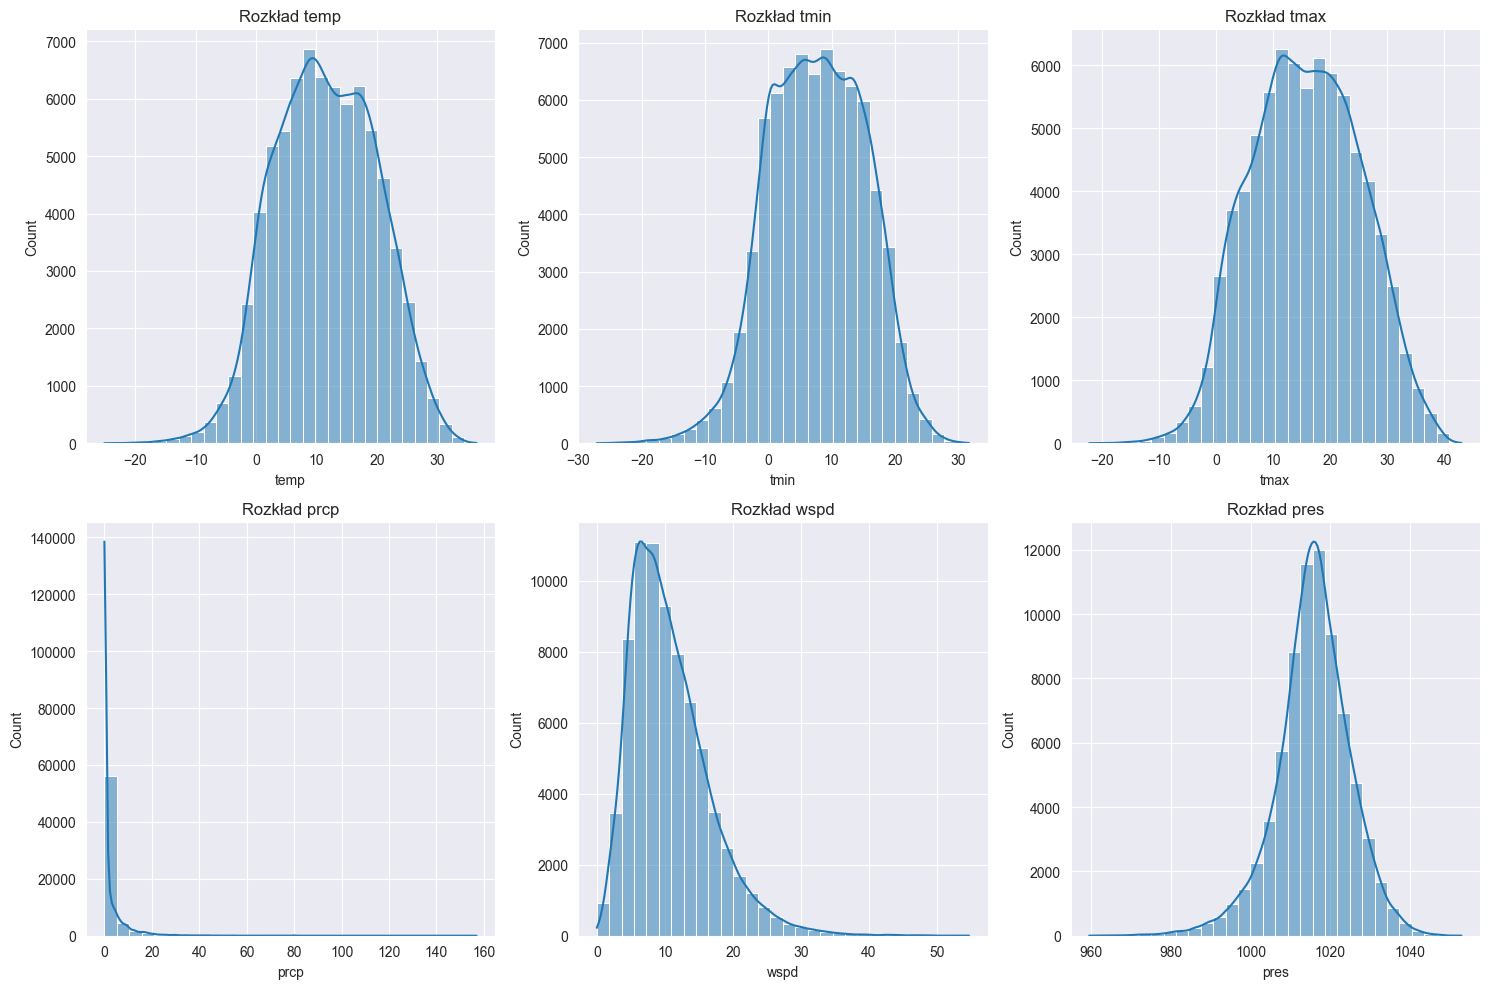

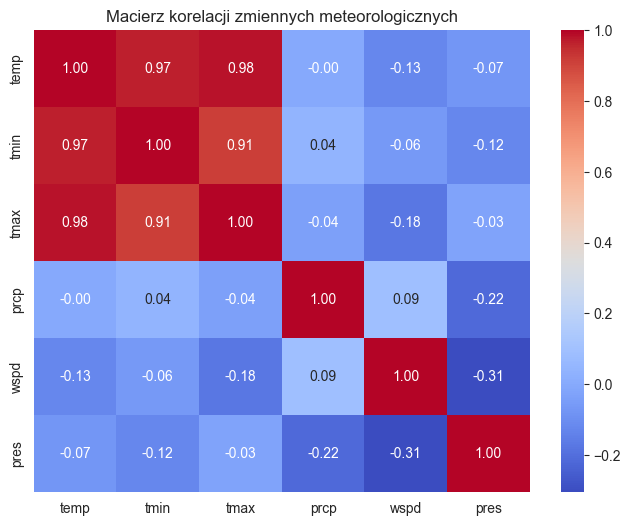

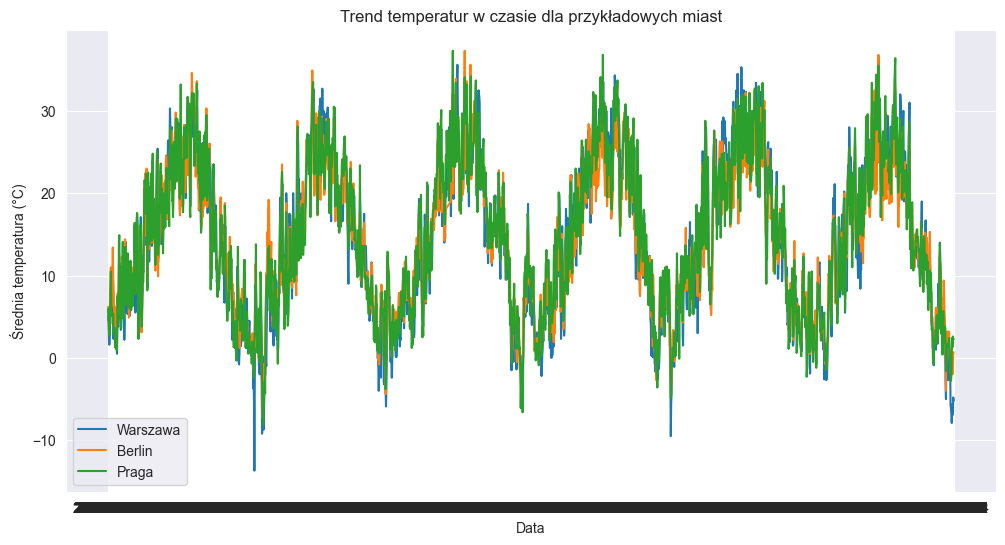

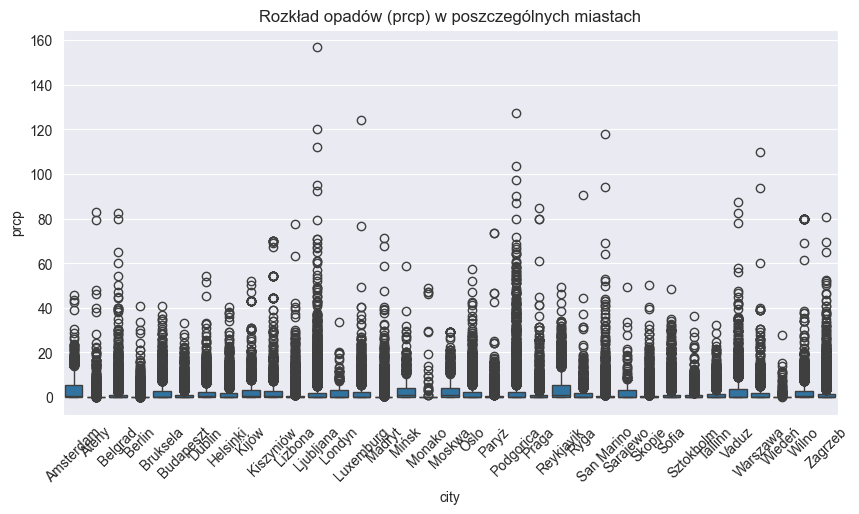

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie wyczyszczonego datasetu
df = pd.read_csv("european_capitals_history_clean2.csv")

# --- Podstawowa analiza statystyczna ---
print("Podstawowe informacje o datasetcie:")
print(df.info())
print("\nOpis statystyczny danych meteorologicznych:")
print(df[['temp', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']].describe())

# --- Liczba wpisów na miasto ---
print("\nLiczba wpisów dla każdego miasta:")
print(df['city'].value_counts())

# --- Wizualizacja rozkładów danych ---
weather_cols = ['temp', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']

plt.figure(figsize=(15,10))
for i, col in enumerate(weather_cols):
    plt.subplot(2,3,i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Rozkład {col}')
plt.tight_layout()
plt.show()

# --- Korelacja między zmiennymi meteorologicznymi ---
corr = df[weather_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji zmiennych meteorologicznych')
plt.show()

# --- Trend temperatur w czasie dla przykładowych miast ---
sample_cities = ['Warszawa','Berlin','Praga']
plt.figure(figsize=(12,6))

for city in sample_cities:
    city_data = df[df['city']==city]
    plt.plot(city_data['time'], city_data['tmax'], label=city)

plt.xlabel('Data')
plt.ylabel('Średnia temperatura (°C)')
plt.title('Trend temperatur w czasie dla przykładowych miast')
plt.legend()
plt.show()

# --- Analiza opadów ---
plt.figure(figsize=(10,5))
sns.boxplot(x='city', y='prcp', data=df)
plt.xticks(rotation=45)
plt.title('Rozkład opadów (prcp) w poszczególnych miastach')
plt.show()


In [60]:
import plotly.express as px
df_avg = df.groupby(['city', 'lat', 'lon'], as_index=False)['temp'].mean()

# Mapa punktowa
fig = px.scatter_geo(
    df_avg,
    lat='lat',
    lon='lon',
    color='temp',
    size='temp',
    hover_name='city',
    projection='natural earth',
    color_continuous_scale='RdYlBu_r',
    title='Średnia temperatura w miastach'
)

fig.update_layout(geo=dict(showland=True, landcolor="lightgray"))
fig.show()

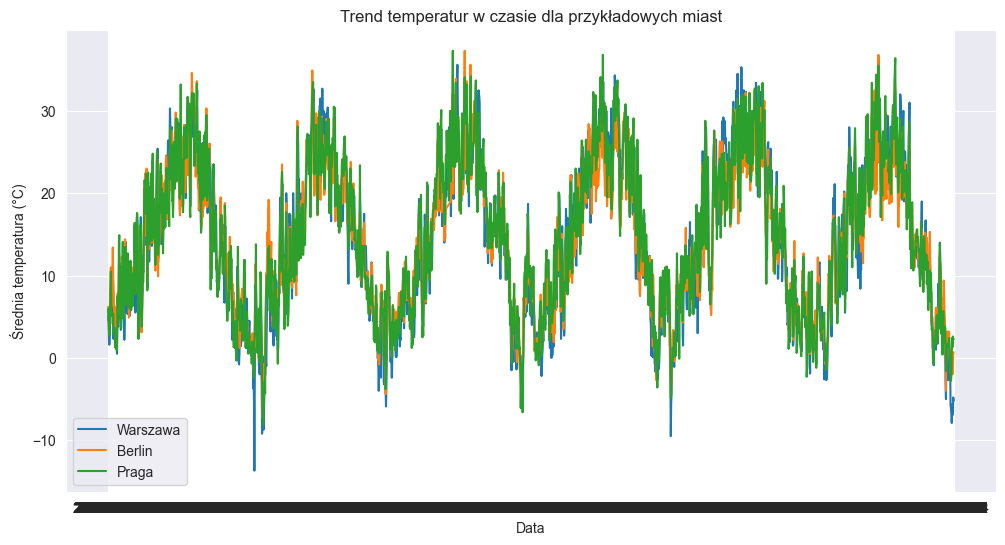

In [61]:
sample_cities = ['Warszawa','Berlin','Praga']
plt.figure(figsize=(12,6))

for city in sample_cities:
    city_data = df[df['city']==city]
    plt.plot(city_data['time'], city_data['tmax'], label=city)

plt.xlabel('Data')
plt.ylabel('Średnia temperatura (°C)')
plt.title('Trend temperatur w czasie dla przykładowych miast')
plt.legend()
plt.show()